# Business Problem

ABC Bank faces the challenge of identifying high-value customer segments to drive revenue growth. By leveraging data analysis and clustering techniques, the bank can pinpoint the most profitable groups of their customer base. Once identified, targeted marketing strategies, such as targeted offers and influencers, can be pursued to engage these high-value segments effectively. Adhering to data privacy and ethical standards will also be crucial for maintaining trust and sustaining long-term growth.

# Data Summary

This dataset, Credit Card Transaction Records Dataset, is from Kaggle. It contains over 1.3 million records of credit card transactions, including details about transaction times, amounts, and personal and merchant information. 

For the purposes of running analysis and models efficiently, the data set was trimmed to 50,000 rows. 

# Project Summary

In this project, I focused on segmenting the user base by creating clusters using KMeans, Birch, and DBSCAN clustering algorithms. DBSCAN delivered the best clustering results in terms of density and shape, but KMeans proved to be more representative of the overall dataset, making it the best choice for further analysis. 

After applying KMeans, I integrated the resulting clusters into the original dataframe, which allowed for analysis of each user-segment. Through this analysis, I identified which customer segment presented the greatest potential for profit. The highest-value segment (cluster 4) was then examined in detail to understand its characteristics and behavior. The analysis allowed for targeted marketing strategies aimed at maximizing revenue and growth opportunities.

# Import Packages and Data

In [68]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from geopy.distance import great_circle
np.random.seed(19)

from scipy.stats import chi2_contingency
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA

from sklearn.cluster import KMeans, Birch, DBSCAN, OPTICS
from sklearn.metrics import silhouette_score, calinski_harabasz_score

In [2]:
import sys
import os

# Add the src directory to the Python path
sys.path.append(os.path.abspath('../src'))

# Import all classes from classes.py
from classes import *

In [3]:
cc_df = pd.read_csv("../data/credit_card_purchases_sampled.csv")

In [4]:
cc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             50000 non-null  int64  
 1   trans_date_trans_time  50000 non-null  object 
 2   cc_num                 50000 non-null  int64  
 3   merchant               50000 non-null  object 
 4   category               50000 non-null  object 
 5   amt                    50000 non-null  float64
 6   first                  50000 non-null  object 
 7   last                   50000 non-null  object 
 8   gender                 50000 non-null  object 
 9   street                 50000 non-null  object 
 10  city                   50000 non-null  object 
 11  state                  50000 non-null  object 
 12  zip                    50000 non-null  int64  
 13  lat                    50000 non-null  float64
 14  long                   50000 non-null  float64
 15  ci

In [5]:
# Drop included index col
cc_df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [6]:
cc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   trans_date_trans_time  50000 non-null  object 
 1   cc_num                 50000 non-null  int64  
 2   merchant               50000 non-null  object 
 3   category               50000 non-null  object 
 4   amt                    50000 non-null  float64
 5   first                  50000 non-null  object 
 6   last                   50000 non-null  object 
 7   gender                 50000 non-null  object 
 8   street                 50000 non-null  object 
 9   city                   50000 non-null  object 
 10  state                  50000 non-null  object 
 11  zip                    50000 non-null  int64  
 12  lat                    50000 non-null  float64
 13  long                   50000 non-null  float64
 14  city_pop               50000 non-null  int64  
 15  jo

In [7]:
cc_df.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,merch_zipcode
0,2020-06-03 12:43:29,581293083266,fraud_Reilly LLC,home,77.90,William,Thomas,M,39227 Mcpherson Shoals,Lahoma,...,-98.0727,1078,Podiatrist,1989-10-06,f3d6477a2e1bb93f4c1b18adf2a607d1,1370263409,36.566036,-97.237692,0,74644.0
1,2020-04-18 19:57:14,340953839692349,fraud_Hamill-D'Amore,health_fitness,47.78,Tyler,Wright,M,615 Clarke Spring Apt. 172,Warren,...,-82.9832,134056,"Doctor, hospital",1980-05-18,0fbb710e4a8d253580751528c7a2cd92,1366315034,42.837893,-83.228559,0,48370.0
2,2019-01-14 22:23:54,3595192916105588,"fraud_Kerluke, Considine and Macejkovic",misc_net,690.81,Dustin,Roberts,M,3283 James Station,Fayetteville,...,-79.0080,238602,"Scientist, research (maths)",1993-05-14,cc0ce65bebf95fd2b2f76b3f8d2c15f7,1326579834,35.439158,-78.609636,1,27521.0
3,2019-08-02 09:31:48,4390966588600992777,fraud_Torp-Labadie,gas_transport,65.85,Kyle,Simmons,M,8149 Harris Divide,Oklahoma City,...,-97.5583,640470,Advertising copywriter,1966-06-24,d5b4400db9755821f60fa0bec602b2d2,1343899908,36.531040,-97.737859,0,74640.0
4,2019-01-14 16:03:53,36485887555770,"fraud_Reichert, Shanahan and Hayes",shopping_net,67.11,Michael,Gross,M,230 Ryan Tunnel Apt. 025,Fulton,...,-82.8342,267,Facilities manager,2005-01-29,6270f5ee1b11d2354d6828508860f1ed,1326557033,41.189226,-81.864998,0,44280.0


# Exploratory Data Analysis and Cleaning

## Column Re-labeling

In [8]:
# Cast cc_num to string
cc_df['cc_num'] = cc_df['cc_num'].astype(str)

# Cast trans_date_trans_time to datetime
cc_df['trans_date_trans_time'] = pd.to_datetime(cc_df['trans_date_trans_time'])
cc_df['dob'] = pd.to_datetime(cc_df['dob'])

# Rename column
cc_df.rename(columns={'trans_date_trans_time' : 'timestamp'}, inplace=True)

# Drop column
cc_df.drop(['unix_time'], axis=1, inplace=True)

## Missingness

The only column with missing values is 'merch_zipcode'. Lets investigate this column to see the effect dropping the columns would have. 

In [9]:
# Calculate the total number of rows
total_rows = cc_df.shape[0]

# Calculate the number of non-null merch_zipcode values
non_null_merch_zipcode = cc_df['merch_zipcode'].notnull().sum()

# Calculate the number of missing merch_zipcode values
missing_merch_zipcode = total_rows - non_null_merch_zipcode

# Calculate the percentage of missing values
percentage_missing = (missing_merch_zipcode / total_rows) * 100

# Display the percentage of missing values
print(f"Percentage of merch_zipcode values that are missing: {percentage_missing:.2f}%")

Percentage of merch_zipcode values that are missing: 15.07%


Given that ~15% of the merchants zipcode are missing, dropping this many rows is difficult to do. But, there will still be 42,000 transactions. 

When the model is being run, if the merchant zipcode is not an important feature, this decision will be revisited. 

In [10]:
# Drop NaNs
cc_df.dropna(subset=['merch_zipcode'], inplace=True)

# Cast zip to string
cc_df['merch_zipcode'] = cc_df['merch_zipcode'].astype(str)

## Numerical Columns

In [11]:
cc_df.describe()

,timestamp,amt,zip,lat,long,city_pop,dob,merch_lat,merch_long,is_fraud
count,42464,42464.000000,42464.000000,42464.000000,42464.000000,4.246400e+04,42464,42464.000000,42464.000000,42464.000000
mean,2019-10-02 15:50:25.013799936,136.132126,46575.423370,38.595645,-88.780103,8.737273e+04,1973-03-04 11:51:47.611152992,38.601349,-88.784797,0.149845
min,2019-01-01 00:17:40,1.000000,1257.000000,20.027100,-155.488000,2.300000e+01,1924-10-30 00:00:00,19.399206,-156.118071,0.000000
25%,2019-06-02 16:48:16.750000128,11.947500,24070.000000,35.058300,-95.350900,8.040000e+02,1961-12-05 00:00:00,35.175649,-95.421944,0.000000
50%,2019-10-02 03:56:53,53.620000,45801.000000,39.371600,-86.545700,2.501000e+03,1974-12-24 00:00:00,39.369549,-86.605711,0.000000
75%,2020-01-30 21:56:41.750000128,106.400000,68463.000000,41.603000,-79.808900,1.886275e+04,1986-11-24 00:00:00,41.704286,-79.766672,0.000000
max,2020-06-21 11:59:45,9999.390000,99323.000000,48.887800,-67.950300,2.906700e+06,2005-01-29 00:00:00,49.116921,-67.027467,1.000000
std,NaN,256.452379,25996.838552,4.551974,12.375770,2.979376e+05,NaN,4.555899,12.372878,0.356923


### Timestamp

When the fraudulent transactions occur could contain valuable information for the models. As such, lets expand out the timestamp to provide more information. 

In [12]:
# Expand the timestamp column
cc_df['hour'] = cc_df['timestamp'].dt.hour
cc_df['day_of_week'] = cc_df['timestamp'].dt.dayofweek
cc_df['month'] = cc_df['timestamp'].dt.month
cc_df['is_weekend'] = cc_df['timestamp'].dt.dayofweek >= 5

# Create time of day categories
def categorize_time_of_day(hour):
    if 0 <= hour < 6:
        return 'night'
    elif 6 <= hour < 12:
        return 'morning'
    elif 12 <= hour < 18:
        return 'afternoon'
    else:
        return 'evening'

cc_df['time_of_day'] = cc_df['hour'].apply(categorize_time_of_day)

# Drop the original timestamp if not needed
cc_df.drop(columns=['timestamp'], inplace=True)

### Customer and Merchant Longitude and Latitude

In [13]:
# Calculate distance feature
def calculate_distance(row):
    transaction_location = (row['lat'], row['long'])
    merchant_location = (row['merch_lat'], row['merch_long'])
    return great_circle(transaction_location, merchant_location).miles

# Apply distance calculation
cc_df['distance_to_merchant'] = cc_df.apply(calculate_distance, axis=1)

# Drop the individual location columns
cc_df.drop(columns=['lat', 'long', 'merch_lat', 'merch_long'], inplace=True)

While this column provides great information, it is not feasible to assume that in the real world we will have access to both the latitude and longitude coordinates of both the customer and the merchant. As such, we will drop this column.

In [14]:
# Drop the column
cc_df.drop(columns=['distance_to_merchant'], inplace=True)

## Categorical Columns

### Customer Count 

In [15]:
print(f"There are {cc_df['cc_num'].nunique()} unique customers in the dataset.")

There are 980 unique customers in the dataset.


### Merchant

In [16]:
cc_df['merchant'].value_counts()

merchant
fraud_Kilback LLC         159
fraud_Boyer PLC           144
fraud_Cormier LLC         142
fraud_Kuhn LLC            123
fraud_Schumm PLC          116
                         ... 
fraud_Johnston-Casper      19
fraud_Treutel-King         18
fraud_Smitham-Schiller     18
fraud_Bednar Inc           17
fraud_Kris-Kertzmann       14
Name: count, Length: 693, dtype: int64

It appears that all of the entires begin with 'fraud_'. If they do, lets remove the extraneous wording. 

In [17]:
# Investigate the column
all_fraud = cc_df['merchant'].str.startswith('fraud_').all()
print(f"Do all merchants start with 'fraud_'? {all_fraud}")

# Remove the text at the beginning of each entry
cc_df['merchant'] = cc_df['merchant'].str.replace('^fraud_', '', regex=True)

# Check work
cc_df['merchant'].value_counts()

Do all merchants start with 'fraud_'? True


merchant
Kilback LLC         159
Boyer PLC           144
Cormier LLC         142
Kuhn LLC            123
Schumm PLC          116
                   ... 
Johnston-Casper      19
Treutel-King         18
Smitham-Schiller     18
Bednar Inc           17
Kris-Kertzmann       14
Name: count, Length: 693, dtype: int64

Given the high cardinality of the column and that there is a category column that labels the transaction in a more conventional sense, the merchant column will be dropped. 

If the models performance does not reach an adequate level, the inclusion of this column will be revisted. 

In [18]:
# Drop column
cc_df.drop(['merchant'], axis=1, inplace=True)

### Category

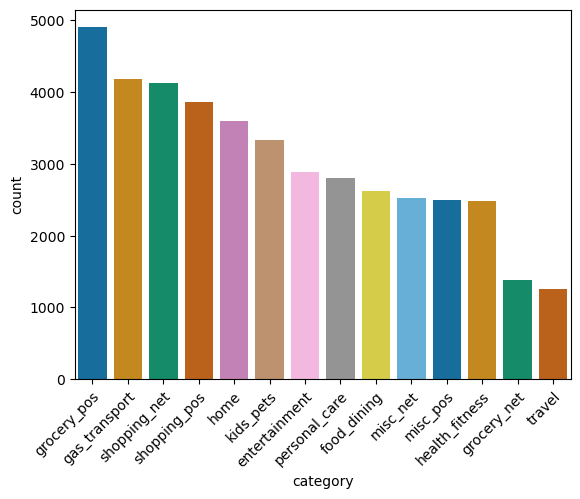

In [19]:
# Create category counts
category_value_counts = cc_df['category'].value_counts()

# Convert the Series to a DataFrame for easier plotting
category_df = category_value_counts.reset_index()
category_df.columns = ['category', 'count']

# Plot
sns.barplot(x='category', y='count', data=category_df, hue='category', palette=sns.color_palette("colorblind"))
plt.xticks(rotation=45, ha='right', rotation_mode='anchor')
plt.show()

### Gender

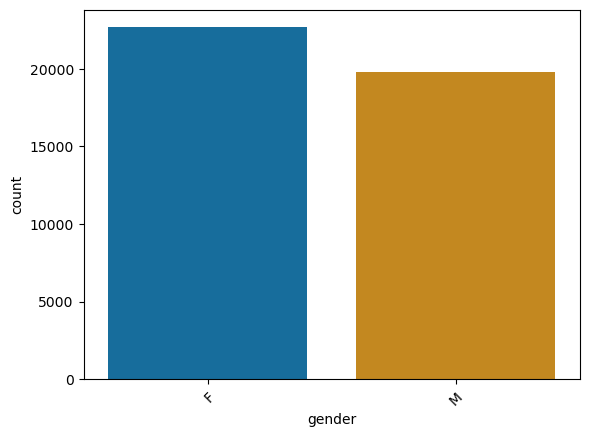

In [20]:
# Create category counts
gender_value_counts = cc_df['gender'].value_counts()

# Convert the Series to a DataFrame for easier plotting
category_df = gender_value_counts.reset_index()
category_df.columns = ['gender', 'count']

# Plot
sns.barplot(x='gender', y='count', data=category_df, hue='gender', palette=sns.color_palette("colorblind"))
plt.xticks(rotation=45, ha='right', rotation_mode='anchor')
plt.show()

### Job

In [21]:
# Covert the rows to lowercase and remove whitespace
cc_df['job'] = cc_df['job'].str.lower().str.strip()

In [22]:
# Define a mapping for collapsing job titles with unique titles
job_mapping = {
    # Engineering and Technology
    'engineering and technology': [
        'engineer', 'technical', 'aeronautical engineer', 'biomedical engineer', 'engineering geologist',
        'environmental engineer', 'it consultant', 'multimedia programmer', 'programmer', 'technology',
        'electronics engineer', 'naval architect', 'materials engineer', 'mining engineer', 'mechanical engineer',
        'chemical engineer', 'energy engineer', 'electrical engineer', 'drilling engineer', 'production engineer',
        'engineer, broadcasting (operations)', 'maintenance engineer', 'structural engineer', 'water engineer',
        'petroleum engineer', 'hydrologist', 'systems analyst', 'manufacturing systems engineer', 'building services engineer',
        'civil engineer, contracting', 'communications engineer', 'engineer, automotive', 'engineer, control and instrumentation',
        'physiotherapist', 'engineer, production', 'engineer, biomedical', 'engineer, mining', 'technical brewer', 
        'manufacturing engineer', 'engineer, electronics', 'engineer, petroleum', 'engineer, agricultural', 'engineer, land',
        'engineer, aeronautical', 'engineer, civil (contracting)', 'control and instrumentation engineer', 'network engineer',
        'broadcast engineer', 'data scientist', 'applications developer', 'programmer, multimedia', 'programmer, applications',
        'technical sales engineer', 'telecommunications researcher', 'industrial/product designer', 'seismic interpreter',
        'environmental health practitioner', 'software engineer', 'site engineer', 'make', 'metallurgist',
        'product/process development scientist', 'engineer, technical sales', 'engineer, communications', 'designer, multimedia',
        'garment/textile technologist', 'mudlogger', 'pilot, airline', 'contractor', 'energy manager', 'database administrator',
        'geophysicist/field seismologist', 'armed forces logistics/support/administrative officer', 'intelligence analyst',
        'architectural technologist', 'design engineer', 'armed forces technical officer', 'contracting civil engineer',
    ],
    
    # Medical and Healthcare
    'medical and healthcare': [
        'medical professional', 'psychologist', 'psychotherapist', 'psychotherapist, child', 'psychologist, clinical',
        'psychiatrist', 'radiographer, diagnostic', 'radiographer, therapeutic', 'physiological scientist', 'health physicist',
        'medical physicist', 'occupational therapist', 'counsellor', 'therapist', 'nutritionist', 'pharmacologist', 'paramedic',
        'pathologist', 'immunologist', 'podiatrist', 'chiropodist', 'dance movement psychotherapist', 'hospital doctor',
        'scientist, audiological', 'toxicologist', 'private music teacher', 'forensic psychologist', 'child psychotherapist',
        'learning disability nurse', 'dispensing optician', 'health and safety adviser', 'mental health nurse', 'phytotherapist',
        'biomedical scientist', 'community pharmacist', 'nutritional therapist', 'clinical research associate', 'clinical biochemist',
        'osteopath', 'orthoptist', 'medical technical officer', 'veterinary surgeon', 'psychologist, forensic', 'surgeon',
        'exercise physiologist', 'occupational psychologist', 'medical sales representative', 'cytogeneticist', 'occupational hygienist',
        'counselling psychologist', 'psychologist, counselling', 'fisheries officer', 'physiotherapist', 'psychologist, sport and exercise',
        'pharmacist, community', 'psychiatric nurse', 'doctor, general practice', 'nurse, children\'s', 'paediatric nurse',
        'therapist, occupational', 'medical secretary', 'diagnostic radiographer', 'therapist, sports', 'therapist, drama',
        'therapist, horticultural', 'therapist, music', 'oncologist', 'embryologist, clinical', 'neurosurgeon', 'pharmacist, hospital',
        'optometrist', 'health visitor', 'clinical psychologist', 'herbalist', 'acupuncturist', 'homeopath', 'animal nutritionist',
        'general practice doctor', 'doctor, hospital', 'hospital pharmacist', 'nurse, mental health', 'therapist, art',
        'health promotion specialist', 'counselling psychologist', 'clinical psychologist', 'animal technologist',
        'horticultural therapist', 'sport and exercise psychologist', 'ambulance person',
    ],
    
    # Education and Research
    'education and research': [
        'teacher', 'lecturer', 'research scientist', 'academic librarian', 'educator', 'education officer', 
        'training and development officer', 'higher education careers adviser', 'secondary school teacher', 'early years teacher',
        'further education lecturer', 'learning mentor', 'science writer', 'outdoor activities/education manager',
        'archaeologist', 'assistant professor', 'professor emeritus', 'conservator, museum/gallery', 'museum/gallery exhibitions officer',
        'librarian, academic', 'teacher, special educational needs', 'education officer, museum', 'research scientist (physical sciences)',
        'education officer, community', 'research officer, trade union', 'research officer, political party', 'museum education officer',
        'educational psychologist', 'associate professor', 'tefl teacher', 'english as a second language teacher',
        'english as a foreign language teacher', 'private music teacher', 'sub', 'librarian, public', 'special educational needs teacher',
        'teacher, early years/pre', 'teacher, secondary school', 'teacher, english as a foreign language', 'lecturer, higher education',
        'education administrator', 'teaching laboratory technician', 'community education officer', 'primary school teacher',
        'teacher, adult education', 'researcher', 'curriculum developer', 'higher education administrator', 'program evaluator',
        'academic advisor', 'education policy analyst', 'training and development manager', 'instructional designer',
        'careers information officer', 'programme researcher, broadcasting/film/video', 'field trials officer',
        'armed forces training and education officer', 'administrator, education', 'special educational needs teacher',
        'social researcher', 'lexicographer', 'herpetologist', 'archivist', 'careers adviser', 'interpreter'
    ],
    
    # Arts, Media, and Design
    'arts, media, and design': [
        'designer', 'artist', 'media planner', 'advertising account planner', 'copywriter, advertising', 'journalist',
        'film/video editor', 'radio producer', 'television/film/video producer', 'music tutor', 'art therapist',
        'designer, television/film set', 'print designer', 'multimedia artist', 'exhibition designer', 'magazine features editor',
        'clothing/textile technologist', 'musician', 'producer, television/film/video', 'photographer', 'video editor',
        'stage manager', 'producer, radio', 'radio broadcast assistant', 'television production assistant', 'press photographer',
        'broadcast presenter', 'camera operator', 'set designer', 'theatre manager', 'theatre director', 'curator',
        'press photographer', 'television floor manager', 'exhibitions officer, museum/gallery', 'editor, commissioning',
        'editor, film/video', 'production assistant, radio', 'media buyer', 'music therapist', 'interior and spatial designer',
        'textile designer', 'glass blower/designer', 'arts development officer', 'community arts worker', 'designer, ceramics/pottery',
        'fine artist', 'designer, industrial/product', 'designer, exhibition/display', 'designer, jewellery', 'copy',
        'designer, furniture', 'designer, interior/spatial', 'animator', 'illustrator', 'special effects artist',
        'art gallery manager', 'visual merchandiser', 'gaffer', 'colour technologist', 'bookseller', 'magazine journalist',
        'editor, magazine features', 'programmer, multimedia', 'product designer', 'fashion designer', 'jewellery designer',
        'environmental education officer', 'writer', 'ceramics designer', 'architect', 'presenter, broadcasting',
        'conservator, furniture', 'broadcast journalist',
    ],
    
    # Business and Management
    'business and management': [
        'chief executive officer', 'chief financial officer', 'chief operating officer', 'chief technology officer',
        'chief strategy officer', 'manager', 'business consultant', 'management consultant', 'sales professional',
        'marketing', 'public relations', 'human resources officer', 'operations manager', 'executive', 'facilities manager',
        'purchasing manager', 'product manager', 'chief marketing officer', 'call centre manager', 'buyer, industrial',
        'consulting and advisory', 'production manager', 'sales executive', 'sales professional, it', 'health service manager',
        'systems developer', 'it trainer', 'business analyst', 'public relations account executive', 'retail merchandiser',
        'retail manager', 'logistics and distribution manager', 'charity fundraiser', 'human resources consultant',
        'commercial manager', 'marketing executive', 'sales promotion account executive', 'business development manager',
        'project manager', 'account manager', 'hr manager', 'business owner', 'management accountant', 'financial planner',
        'investment banker', 'investment analyst', 'accountant', 'credit controller', 'mortgage adviser', 'treasury analyst',
        'real estate agent', 'stockbroker', 'business adviser', 'company director', 'trading standards officer', 'mortgage broker',
        'business manager', 'public affairs consultant', 'external auditor', 'tax adviser', 'accounting technician',
        'non-profit manager', 'campaign manager', 'marketing manager', 'accountancy manager', 'management analyst',
        'strategic planner', 'business development executive', 'director, corporate affairs', 'director, marketing',
        'business intelligence analyst', 'business operations manager', 'commercial director', 'communications manager',
        'director of operations', 'financial analyst', 'insurance underwriter', 'management consultant',
        'financial adviser', 'chartered public finance accountant', 'quantity surveyor', 'surveyor, land/geomatics',
        'prison officer', 'pensions consultant', 'comptroller', 'land/geomatics surveyor', 'race relations officer',
        'financial trader', 'building surveyor', 'scientist, research (maths)', 'scientist, marine', 'claims inspector/assessor',
        'scientist, biomedical', 'senior tax professional/tax inspector', 'dealer', 'development worker, community',
        'operations geologist', 'barrister\'s clerk', 'geoscientist', 'lecturer, further education', 'historic buildings inspector/conservation officer',
        'chartered loss adjuster', 'travel agency manager', 'commercial/residential surveyor', 'tree surgeon', 'futures trader',
        'development worker, international aid', 'tax inspector', 'journalist, newspaper', 'heritage manager', 'press sub',
        'fitness centre manager', 'amenity horticulturist', 'administrator', 'equality and diversity officer', 'physicist, medical',
        'commercial horticulturist', 'insurance risk surveyor', 'advice worker', 'building control surveyor', 'risk analyst',
        'wellsite geologist', 'tourist information centre manager', 'leisure centre manager', 'politician\'s assistant',
        'waste management officer', 'secretary/administrator', 'administrator, local government', 'trade mark attorney',
        'investment banker, corporate', 'arboriculturist', 'museum/gallery conservator', 'statistician', 'surveyor, minerals',
        'geologist, wellsite', 'optician, dispensing', 'administrator, charities/voluntary organisations', 'furniture designer',
        'sports development officer', 'patent attorney', 'market researcher', 'farm manager', 'research scientist (life sciences)',
        'operational researcher', 'land', 'warden/ranger', 'regulatory affairs officer', 'aid worker', 'landscape architect',
        'web designer', 'insurance broker', 'accountant, chartered public finance', 'pension scheme manager', 'research scientist (maths)',
        'surveyor, rural practice', 'surveyor, mining', 'theme park manager', 'retail banker', 'scientist, research (physical sciences)',
        'conservation officer, historic buildings', 'equities trader', 'emergency planning/management officer', 'field seismologist',
        'corporate investment banker', 'geologist, engineering', 'licensed conveyancer', 'cartographer', 'scientist, physiological',
        'records manager', 'rural practice surveyor', 'planning and development surveyor', 'chartered accountant', 'quarry manager',
        'town planner', 'horticulturist, commercial', 'insurance claims handler', 'advertising copywriter', 'volunteer coordinator',
        'furniture conservator/restorer', 'public house manager', 'sports administrator', 'civil service fast streamer', 'designer, textile',
        'event organiser', 'community development worker', 'hydrographic surveyor', 'commissioning editor', 'air broker', 'cabin crew',
        'engineer, drilling', 'engineer, building services', 'biochemist, clinical', 'economist', 'engineer, maintenance',
        'plant breeder/geneticist', 'chartered legal executive (england and wales)', 'chief of staff', 'information systems manager',
        'engineer, manufacturing', 'scientist, clinical (histocompatibility and immunogenetics)', 'social research officer, government',
        'minerals surveyor', 'scientist, research (medical)', 'research scientist (medical)', 'analytical chemist', 'clinical cytogeneticist',
        'chemist, analytical', 'loss adjuster, chartered', 'teacher, primary school', 'production assistant, television',
        'horticultural consultant', 'engineer, materials', 'air cabin crew', 'investment banker, operational',
        'civil service administrator', 'solicitor, scotland', 'public librarian', 'restaurant manager, fast food',
        'geneticist, molecular', 'estate manager/land agent', 'water quality scientist', 'surveyor, hydrographic', 'dancer',
        'television camera operator', 'accountant, chartered certified', 'tour manager', 'nature conservation officer',
        'personnel officer', 'administrator, arts', 'local government officer', 'engineer, structural', 'buyer, retail',
        'engineer, site', 'location manager', 'information officer', 'merchandiser, retail', 'industrial buyer', 'ship broker',
        'forest/woodland manager', 'accountant, chartered', 'retail buyer', 'advertising account executive', 'barista', 
        'company secretary', 'hotel manager', 'catering manager'
    ],
    
    # Law and Public Service
    'law and public service': [
        'lawyer', 'solicitor', 'barrister', 'legal executive', 'paralegal', 'legal secretary', 'notary public',
        'probate practitioner', 'conveyancer', 'legal adviser', 'police officer', 'firefighter', 'paramedic', 'social worker',
        'probation officer', 'criminologist', 'community support worker', 'coroner', 'legal advisor', 'court usher', 'diplomat',
        'human rights officer', 'immigration officer', 'military officer', 'intelligence officer', 'government administrator',
        'policy analyst', 'legal consultant', 'legal researcher', 'environmental health officer', 'charity officer',
        'emergency planning officer', 'armed forces', 'political researcher', 'researcher, policy', 'public affairs officer',
        'advocate', 'community safety officer', 'law enforcement officer', 'social services manager', 'public services manager',
        'community worker', 'legal compliance officer', 'adviser, business', 'investigator', 'public relations officer',
        'tax adviser', 'trade union representative', 'public policy consultant', 'caseworker', 'data protection officer',
        'civil service', 'foreign service officer', 'human resources officer', 'court clerk', 'legislative assistant',
        'nonprofit administrator', 'social care worker', 'public health inspector', 'social researcher', 'court interpreter',
        'social welfare officer', 'regulatory affairs specialist', 'senior policy advisor', 'legal assistant', 'tax consultant',
        'legal analyst', 'compliance officer', 'charity fundraiser', 'victim support officer', 'police investigator',
        'court reporter', 'forensic accountant', 'legal administrator', 'legal officer', 'compliance manager', 'community organizer',
        'political adviser', 'social justice advocate', 'human resources manager', 'regulatory officer'
    ],
    
    # Science and Environment
    'science and environment': [
        'scientist', 'environmental scientist', 'biologist', 'ecologist', 'geologist', 'chemist', 'physicist', 'climatologist',
        'meteorologist', 'marine biologist', 'zoologist', 'environmental consultant', 'conservationist', 'research scientist',
        'environmental engineer', 'wildlife biologist', 'forensic scientist', 'hydrologist', 'astrobiologist', 'geochemist',
        'oceanographer', 'environmental educator', 'biochemist', 'environmental policy analyst', 'environmental health specialist',
        'environmental protection officer', 'environmental compliance specialist', 'earth scientist', 'toxicologist',
        'forensic ecologist', 'environmental risk assessor', 'environmental manager', 'science communicator', 'nature reserve manager',
        'agronomist', 'environmental researcher', 'sustainable development consultant', 'geophysicist', 'scientific researcher',
        'agriculture consultant', 'forestry officer', 'environmental analyst', 'climate scientist', 'wildlife conservationist',
        'environmental microbiologist', 'environmental geologist', 'renewable energy consultant', 'agricultural scientist',
        'environmental technician', 'sustainable energy specialist', 'science educator', 'aquatic biologist', 'applied scientist',
        'soil scientist', 'biodiversity officer', 'scientific advisor', 'scientific policy advisor', 'research and development scientist',
        'field biologist', 'geotechnical engineer', 'climate change analyst', 'sustainability consultant', 'environmental field officer',
        'natural resource manager', 'biological technician', 'environmental health scientist', 'energy auditor', 'environmental compliance officer',
        'marine scientist', 'conservation scientist', 'environmental assessment specialist', 'hydrogeologist', 'scientific laboratory technician',
        'urban planner', 'conservation biologist', 'waste management specialist', 'audiological scientist', 'operations geologist',
    ],
    
    # Transportation and Logistics
    'transportation and logistics': [
        'logistics manager', 'transport planner', 'supply chain manager', 'transportation coordinator', 'freight forwarder',
        'shipment coordinator', 'distribution manager', 'traffic engineer', 'warehouse manager', 'delivery driver',
        'logistics coordinator', 'transport operator', 'road transport manager', 'air cargo agent', 'sea freight coordinator',
        'logistics analyst', 'import/export coordinator', 'fleet manager', 'route planner', 'transport manager', 'cargo handler',
        'supply chain analyst', 'shipping manager', 'inventory manager', 'logistics consultant', 'transportation specialist',
        'logistics director', 'supply chain director', 'transportation analyst', 'transport operations manager', 'logistics technician',
        'transportation planner', 'transportation manager', 'logistics support officer', 'warehouse operative', 'transit coordinator',
        'shipping coordinator', 'distribution coordinator', 'supply chain consultant', 'traffic manager', 'freight manager',
        'airline operations manager', 'railway manager', 'logistics project manager', 'warehouse supervisor', 'transit planner',
        'import/export manager', 'logistics executive', 'supply chain executive', 'fleet coordinator', 'transportation coordinator',
        'traffic coordinator', 'road transport coordinator', 'port operations manager', 'sea cargo agent', 'air freight manager',
        'transportation operations coordinator', 'rail transport manager', 'distribution executive', 'transportation supervisor', 
        'tourism officer', 'airline pilot', 'air traffic controller', 
    ],
    
    # Agriculture and Rural Affairs
    'agriculture and rural affairs': [
        'farmer', 'agricultural consultant', 'farm manager', 'agricultural engineer', 'agronomist', 'landscaper', 'horticulturalist',
        'forester', 'land agent', 'agriculture adviser', 'veterinary surgeon', 'animal husbandry', 'plant breeder', 'soil scientist',
        'rural surveyor', 'veterinary technician', 'crop scientist', 'animal nutritionist', 'organic farmer', 'agricultural scientist',
        'environmental scientist', 'rural development officer', 'poultry farmer', 'dairy farmer', 'crop consultant', 'landscape architect',
        'agriculture technician', 'rural affairs consultant', 'fisheries officer', 'forestry consultant', 'land management officer',
        'arborist', 'agricultural project manager', 'rural planner', 'horticulture manager', 'animal care technician', 'plant pathologist',
        'livestock manager', 'sustainable agriculture consultant', 'pest control advisor', 'land use planner', 'organic agriculture consultant',
        'rural support officer', 'farm worker', 'agricultural educator', 'sustainable land manager', 'aquaculture manager',
        'soil conservationist', 'agriculture policy advisor', 'organic horticulturist', 'plant scientist', 'livestock advisor',
        'animal behaviorist', 'rural business manager', 'farm consultant', 'agriculture researcher', 'plant protection advisor',
    ],
    
    # Construction and Architecture
    'construction and architecture': [
        'architect', 'construction manager', 'building surveyor', 'quantity surveyor', 'civil engineer', 'site manager',
        'project manager', 'structural engineer', 'quantity surveyor', 'building services engineer', 'architectural technician',
        'urban planner', 'interior designer', 'landscape architect', 'contractor', 'construction estimator', 'construction project manager',
        'building inspector', 'construction engineer', 'design engineer', 'site engineer', 'construction consultant', 'architectural designer',
        'building control officer', 'surveyor', 'project architect', 'construction supervisor', 'project coordinator', 'draftsman',
        'structural draughtsperson', 'landscaping contractor', 'architectural assistant', 'urban designer', 'construction technician',
        'design and build manager', 'facilities manager', 'building conservationist', 'site supervisor', 'property manager',
        'construction director', 'building manager', 'architectural technologist', 'land surveyor', 'building project manager',
        'interior architect', 'development manager', 'residential surveyor', 'commercial surveyor', 'architectural project manager',
        'construction consultant', 'project estimator', 'architectural project coordinator', 'building surveyor', 'commercial property manager',
        'construction design manager', 'site coordinator', 'civil engineering technician', 'structural project manager', 'quantity surveyor',
    ]
}

# Function to map old job titles to new categories
def collapse_jobs(job_title):
    for category, titles in job_mapping.items():
        if job_title in titles:
            return category
    return job_title  # Return the original title if no match is found

# Apply the function to the 'job' column
cc_df['job'] = cc_df['job'].apply(collapse_jobs)

# Confirm actions have condensed the column rows
cc_df['job'].value_counts()

job
business and management          15865
medical and healthcare            7531
engineering and technology        6809
arts, media, and design           6048
education and research            4023
science and environment            905
law and public service             759
transportation and logistics       288
agriculture and rural affairs      236
Name: count, dtype: int64

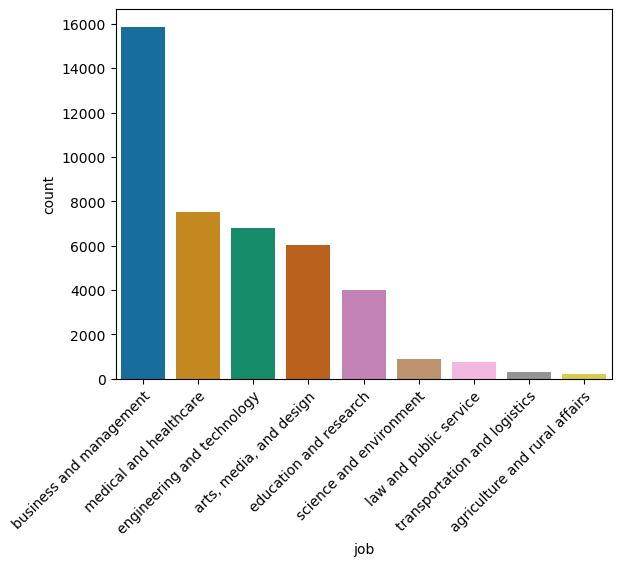

In [23]:
# Create category counts
job_value_counts = cc_df['job'].value_counts().head(20)

# Convert the Series to a DataFrame for easier plotting
category_df = job_value_counts.reset_index()
category_df.columns = ['job', 'count']

# Plot
sns.barplot(x='job', y='count', data=category_df, hue='job', palette=sns.color_palette("colorblind"))
plt.xticks(rotation=45, ha='right', rotation_mode='anchor')
plt.show()

### DOB

It would be nice if we were able to see the age of the user as well as what generation they belong in. Seeing this could help to see if there are different spending habits amongst the users. 

In [24]:
# Calculate age
cc_df['age'] = datetime.now().year - cc_df['dob'].dt.year

In [25]:
# Create a function to define age groups
def age_group(age):
    if age < 10:
        return 'Gen Alpha'
    elif age < 26:
        return 'Gen Z'
    elif age < 42:
        return 'Millennial'
    elif age < 58:
        return 'Gen X'
    elif age < 77:
        return 'Baby Boomer'
    else:
        return 'Silent Generation'

# Apply the function
cc_df['age_group'] = cc_df['age'].apply(age_group)

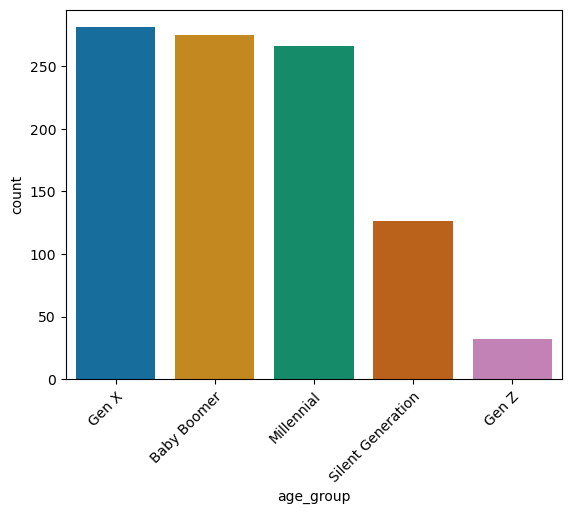

In [26]:
# Aggregate data by cc_num to get unique users
unique_users = cc_df.drop_duplicates(subset=['cc_num'])

# Create category counts based on unique users
age_group_value_counts = unique_users['age_group'].value_counts()

# Convert the Series to a DataFrame for easier plotting
category_df = age_group_value_counts.reset_index()
category_df.columns = ['age_group', 'count']

# Plot
sns.barplot(x='age_group', y='count', data=category_df, hue='age_group', palette=sns.color_palette("colorblind"))
plt.xticks(rotation=45, ha='right', rotation_mode='anchor')
plt.show()

## MultiColinearity Checks

Inside of the dataset, there are multiple columns that are duplicates of each other. Including all of the features will lead to multicolinearity and as such, this needs to be addressed. 

Duplicate columns:
- locations (customer and merchant)
    - street, city, zip
- age
    - dob, age, age_group

Additionally, there are columns that will not provide useful information to the models. 

- customer name
    - first, last
- transaction number

Lets determine how correlated the features are to each other. 

### Numeric Columns

In [27]:
# List of numerical columns
numeric_features = [
    'amt', 
    'city_pop', 
    'age', 
    'hour', 
    'day_of_week', 
    'month'
]

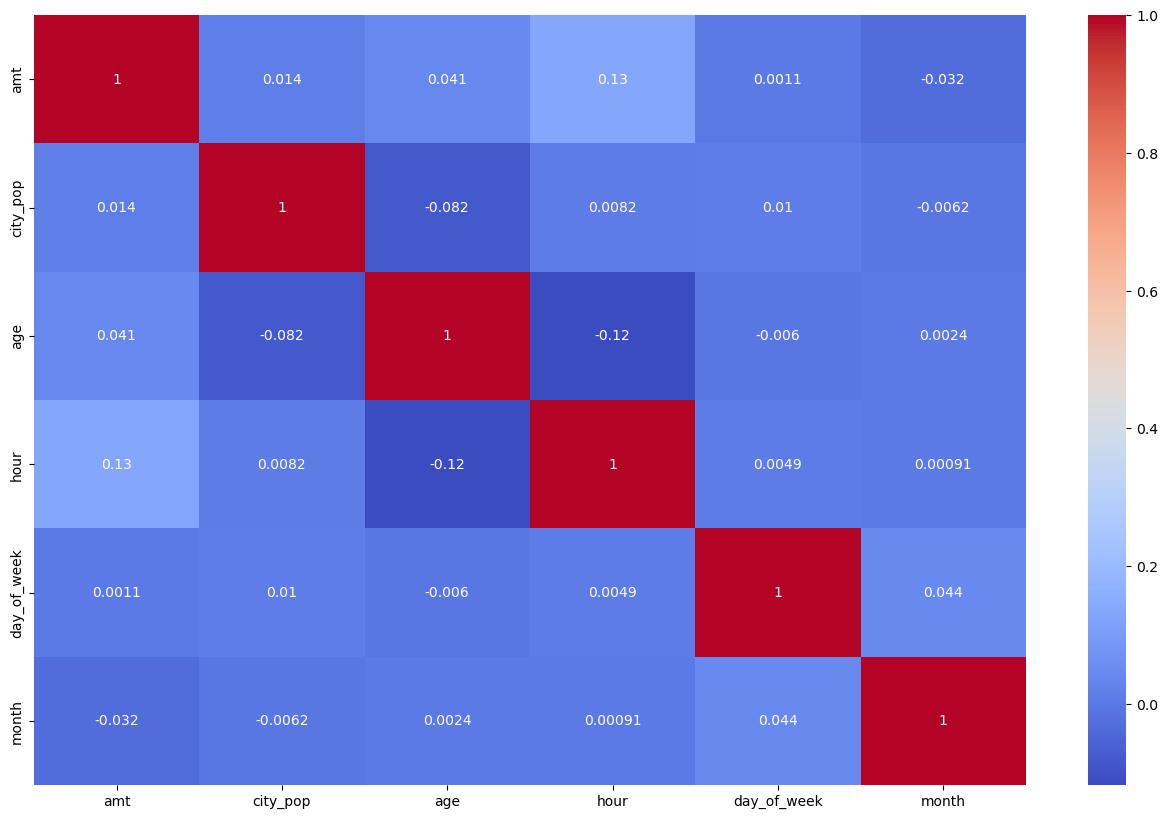

In [28]:
# Calculate correlation matrix
corr_matrix = cc_df[numeric_features].corr()

# Plot heatmap
plt.figure(figsize=(16, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

### Categorical Columns

In [29]:
cc_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 42464 entries, 0 to 49999
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   cc_num         42464 non-null  object        
 1   category       42464 non-null  object        
 2   amt            42464 non-null  float64       
 3   first          42464 non-null  object        
 4   last           42464 non-null  object        
 5   gender         42464 non-null  object        
 6   street         42464 non-null  object        
 7   city           42464 non-null  object        
 8   state          42464 non-null  object        
 9   zip            42464 non-null  int64         
 10  city_pop       42464 non-null  int64         
 11  job            42464 non-null  object        
 12  dob            42464 non-null  datetime64[ns]
 13  trans_num      42464 non-null  object        
 14  is_fraud       42464 non-null  int64         
 15  merch_zipcode  42464 non

In [30]:
# List of categorical columns to be converted
categorical_columns = ['category', 'gender', 'job', 'time_of_day', 'age_group']

# Create dummy variables
cc_df_dummies = pd.get_dummies(cc_df[categorical_columns], drop_first=True)

In [31]:
# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data['feature'] = cc_df_dummies.columns
vif_data['VIF'] = [variance_inflation_factor(cc_df_dummies.values, i) for i in range(cc_df_dummies.shape[1])]

# Filter features with VIF greater than 5
high_vif_features = vif_data[vif_data['VIF'] > 5]

# Print results
if not high_vif_features.empty:
    print("Features with VIF greater than 5:")
    print(high_vif_features)
else:
    print("No multicollinearity detected (all VIFs are less than 5).")

No multicollinearity detected (all VIFs are less than 5).


# Clustering

## Pre-Processing the Data

My assumption is that the clusters will end up centering closely around the different age group categories that were created. People of the same age group should have similar spending patterns. As such, we will store this feature so that we can compare the clusters that are created to the age_group feature. 

In [32]:
# Store age_group for comparison
ge_group = cc_df['age_group']

In [33]:
# See the amount of clusters that exist from this feature (for comparison later on)
cc_df['age_group'].value_counts()

age_group
Gen X                13858
Millennial           13034
Baby Boomer           9909
Silent Generation     4077
Gen Z                 1586
Name: count, dtype: int64

### Dropping Columns

- cc_num
    - Unique identifier for credit card number.
- first, last
    - Personal identifiers.
- street, city, state, zip, merch_zipcode
    - Geographic identifiers that are too specific.
- trans_num
    - Unique transaction identifier.
- dob
    - Already have age and age_group, making dob redundant.

In [34]:
# Make a copy of the orginal dataframe
clustering_df = cc_df.copy()

In [35]:
clustering_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 42464 entries, 0 to 49999
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   cc_num         42464 non-null  object        
 1   category       42464 non-null  object        
 2   amt            42464 non-null  float64       
 3   first          42464 non-null  object        
 4   last           42464 non-null  object        
 5   gender         42464 non-null  object        
 6   street         42464 non-null  object        
 7   city           42464 non-null  object        
 8   state          42464 non-null  object        
 9   zip            42464 non-null  int64         
 10  city_pop       42464 non-null  int64         
 11  job            42464 non-null  object        
 12  dob            42464 non-null  datetime64[ns]
 13  trans_num      42464 non-null  object        
 14  is_fraud       42464 non-null  int64         
 15  merch_zipcode  42464 non

In [36]:
# Drop columns
clustering_df.drop(['cc_num', 'first', 'last', 'street', 'city', 'state', 'zip', 'dob', 'trans_num', 'is_fraud', 'merch_zipcode', 'age_group'], axis=1, inplace=True)

In [37]:
# Convert categorical variable 'gender' to numerical
clustering_df['gender'] = clustering_df['gender'].map({'M': 0, 'F': 1})

# Convert boolean variable 'is_weekend' to numerical
clustering_df['is_weekend'] = clustering_df['is_weekend'].astype(int)

In [38]:
clustering_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 42464 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   category     42464 non-null  object 
 1   amt          42464 non-null  float64
 2   gender       42464 non-null  int64  
 3   city_pop     42464 non-null  int64  
 4   job          42464 non-null  object 
 5   hour         42464 non-null  int32  
 6   day_of_week  42464 non-null  int32  
 7   month        42464 non-null  int32  
 8   is_weekend   42464 non-null  int64  
 9   time_of_day  42464 non-null  object 
 10  age          42464 non-null  int32  
dtypes: float64(1), int32(4), int64(3), object(3)
memory usage: 3.2+ MB


Now we have a DataFrame that contains features that will serve us well when it comes to clustering our groups. 

### Scaling and Encoding the Data

In [39]:
# Label numeric and categorical features
numeric_features = clustering_df.select_dtypes(include=['float64', 'int64', 'int32']).columns
categorical_features = clustering_df.select_dtypes(include=['object']).columns

In [40]:
# Define preprocessing for numerical and categorical data
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [41]:
# Apply preprocessing
clustering_array = preprocessor.fit_transform(clustering_df)

# Create a DataFrame with the transformed data
transformed_clustering_df = pd.DataFrame(
    clustering_array,
    columns=numeric_features.tolist() + list(preprocessor.transformers_[1][1].named_steps['onehot'].get_feature_names_out(categorical_features)),
    index=clustering_df.index
)

In [42]:
transformed_clustering_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 42464 entries, 0 to 49999
Data columns (total 32 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   amt                               42464 non-null  float64
 1   gender                            42464 non-null  float64
 2   city_pop                          42464 non-null  float64
 3   hour                              42464 non-null  float64
 4   day_of_week                       42464 non-null  float64
 5   month                             42464 non-null  float64
 6   is_weekend                        42464 non-null  float64
 7   age                               42464 non-null  float64
 8   category_food_dining              42464 non-null  float64
 9   category_gas_transport            42464 non-null  float64
 10  category_grocery_net              42464 non-null  float64
 11  category_grocery_pos              42464 non-null  float64
 12  category_

## Modeling the Data

To store the results of the models we run, I will create a log that will later be turned into a DataFrame to compare the results.

In [43]:
clustering_log = {}

### Finding K

#### Elbow Plot

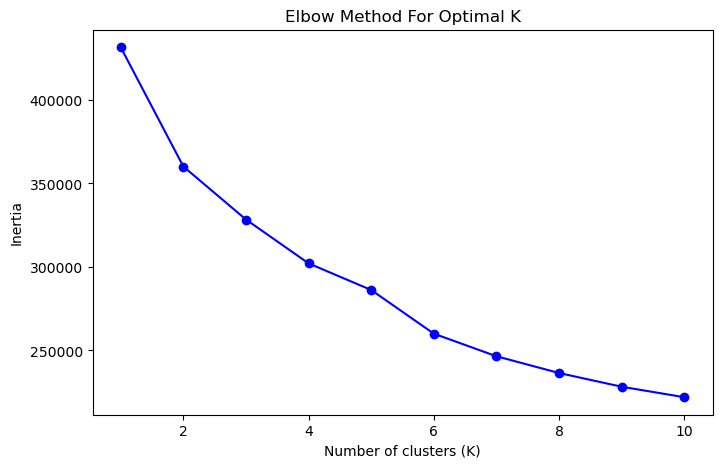

In [44]:
# Elbow Method
inertia = []
K_range = range(1, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(transformed_clustering_df)
    inertia.append(kmeans.inertia_)

# Plot the Elbow plot
plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, 'bo-')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal K')
plt.show()

The elbow appears to be at 5. 

To give us more confidence in the K value that is selected, I will use the silhouette score to gauge how clearly defined the clusters could be. 

#### Silhouette Score

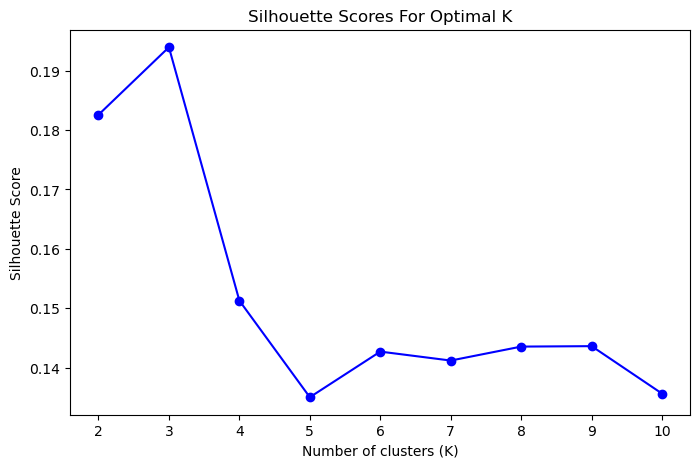

In [45]:
# Initialize variables
silhouette_scores = []
silhouette_scores_dict = {}

# Calculate silhouette scores for each K from 2 to 10
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(transformed_clustering_df)
    score = silhouette_score(transformed_clustering_df, labels)
    
    # Append to list for plotting
    silhouette_scores.append(score)
    
    # Store in dictionary with K as the key
    silhouette_scores_dict[k] = score

# Convert the dictionary to a DataFrame to view scores
silhouette_df = pd.DataFrame(list(silhouette_scores_dict.items()), columns=['K', 'silhouette_score'])

# Plot the Silhouette scores
plt.figure(figsize=(8, 5))
plt.plot(range(2, 11), silhouette_scores, 'bo-')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores For Optimal K')
plt.show()

In [46]:
# Sort DataFrame
silhouette_df.sort_values(by=['silhouette_score'], ascending=False)

,K,silhouette_score
1,3,0.193917
0,2,0.182549
2,4,0.151287
7,9,0.143628
6,8,0.143554
4,6,0.142711
5,7,0.141205
8,10,0.135641
3,5,0.135036


#### Analysis

The elbow plot indicates that the sum of squared distances within clusters shows diminishing returns when increasing the number of clusters beyond both K=5. This suggests that adding more clusters beyond these points provides minimal improvement in clustering performance.

Conversely, the silhouette scores suggest that K=3 would result in the most distinct and well-defined clusters. The best K value (3) results in the highest silhouette score, indicating that the clusters are most clearly separated with this number.

Given the contrary information provided by both the elbow and silhouette score we should visually inspect the data to see if we can determine how many clusters there are. 

To do so, we will need use Principle Component Analysis(PCA) to shrink out feature space from 31 features down to two features. 

## Visually Inspecting the Data

### Using PCA to Reduce the Feature Space

In [47]:
# Define PCA
pca = PCA(n_components=2)

# Create a pipeline that includes preprocessing and PCA
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('pca', pca)
])

In [48]:
# Apply pipline
pca_cluster_array = pipeline.fit_transform(clustering_df)

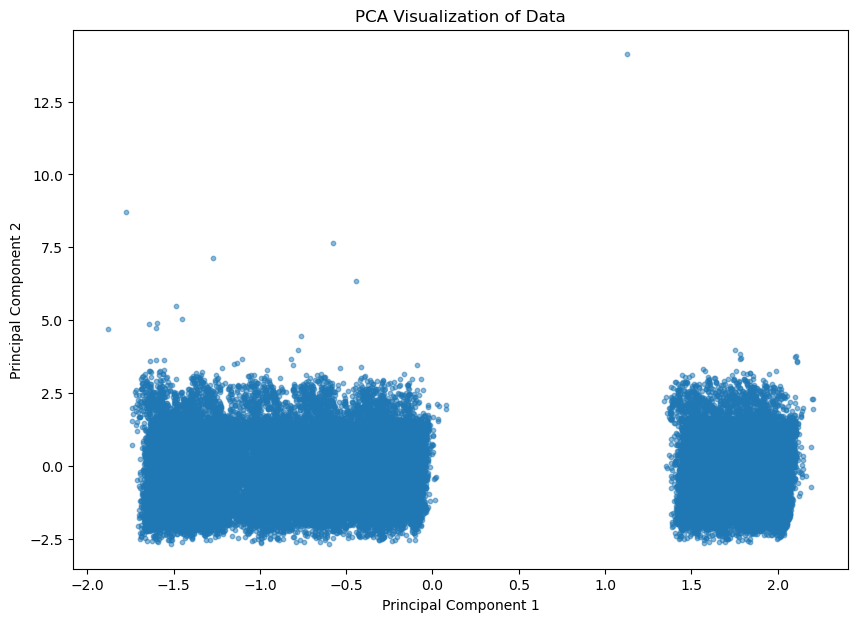

In [49]:
# Create a DataFrame with PCA results
pca_df = pd.DataFrame(data=pca_cluster_array, columns=['PC1', 'PC2'])

# Plot
plt.figure(figsize=(10, 7))
plt.scatter(pca_df['PC1'], pca_df['PC2'], alpha=0.5, s=10)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Visualization of Data')
plt.show()

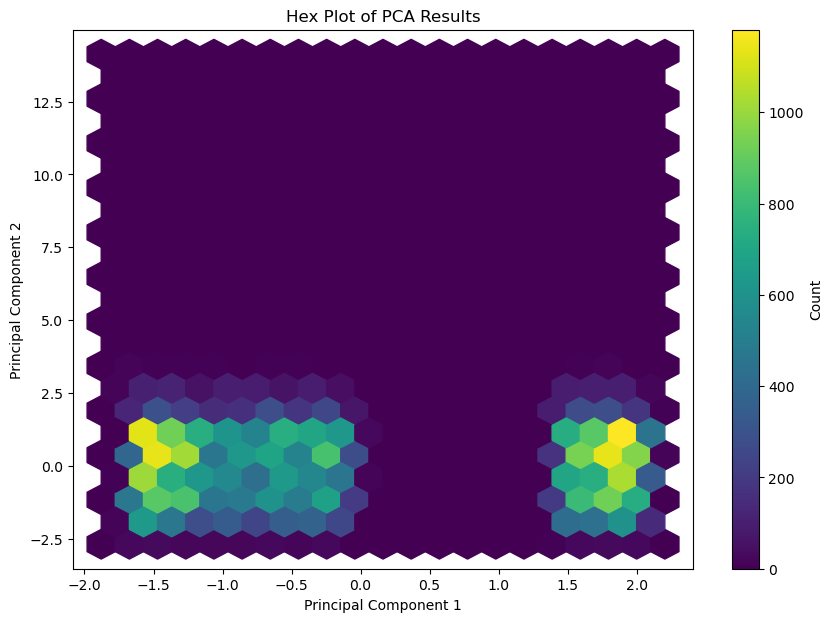

In [50]:
# Hex plot
plt.figure(figsize=(10, 7))
plt.hexbin(pca_df['PC1'], pca_df['PC2'], gridsize=20, cmap='viridis')
plt.colorbar(label='Count')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Hex Plot of PCA Results')
plt.show()

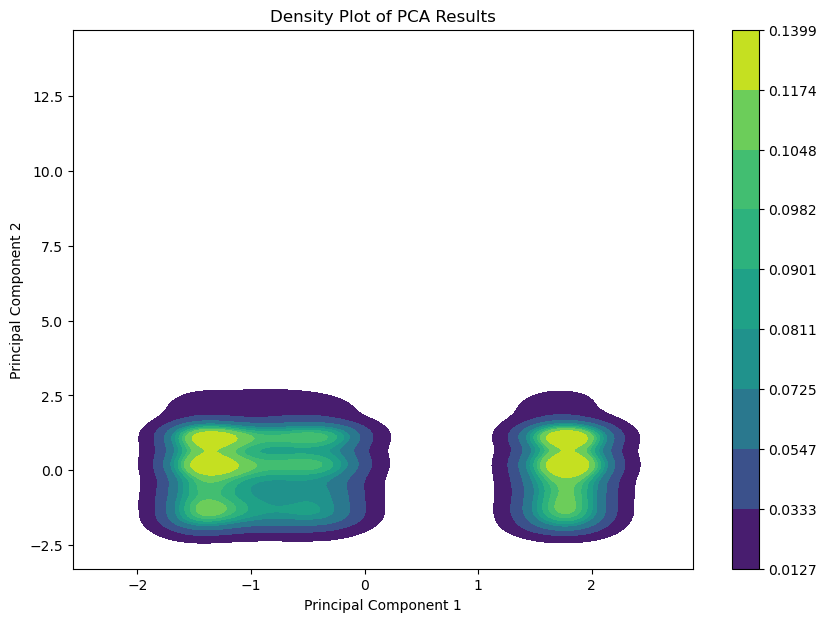

In [51]:
# Density plot
plt.figure(figsize=(10, 7))
sns.kdeplot(data=pca_df, x='PC1', y='PC2', shade=True, cmap='viridis', cbar=True)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Density Plot of PCA Results')
plt.show()

Even though it has the lowest silhouette score, it does appear based on the hex plot and density plot that there are more than 3 distinct clusters. It does appear that there are either 5 or 6 clusters, as such, we will be using the elbow plot to guide us here and will use K=5 moving forward. 

## Functions for Model Evaluation

In [52]:
def evaluate_clustering_model(model, data, model_name, log_dict):
    """
    Evaluates a clustering model and logs the results.
    --
    Inputs:
        model (sklearn clustering model): The clustering model to evaluate.
        data (array-like): The dataset to cluster.
        model_name (str): The name of the model to use as the dictionary key.
        log_dict (dict): The dictionary to store the results in.
    --    
    Output:
        None: The results are stored in log_dict.
    """
    # Initialize and fit the model with the provided parameters
    clustering_model = model
    clusters = clustering_model.fit_predict(data)

    # Evaluate the model
    silhouette = silhouette_score(data, clusters)
    ch_index = calinski_harabasz_score(data, clusters)

    # Store the results
    log_dict[model_name] = {
        'silhouette_score': silhouette,
        'calinski_harabasz_index': ch_index
    }

In [53]:
def visualize_clusters(model, model_name, pca_df):
    """
    Visualizes the clusters identified by a given clustering model.
    --
    Inputs:
        model (sklearn clustering model): The clustering model to fit.
        model_name (str): The name of the model used for labeling.
        pca_df (pandas DataFrame): The DataFrame containing PCA-transformed data.
    --
    Output:
        None: Displays a scatter plot of the clusters.
    """
    # Define the clusters
    clusters = model.fit_predict(pca_df[['PC1', 'PC2']])
    
    # Add the clusters to the DataFrame
    pca_df[f'{model_name}_clusters'] = clusters

    # Plot the clusters
    plt.figure(figsize=(10, 7))
    for cluster in sorted(set(clusters)):
        cluster_data = pca_df[pca_df[f'{model_name}_clusters'] == cluster]
        plt.scatter(cluster_data['PC1'], cluster_data['PC2'], label=f'Cluster {cluster}', alpha=0.5, s=10)
    
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title(f'Clusters Identified by {model_name}')
    plt.legend()
    plt.show()

## K-Means

In [54]:
# Instantiate the model
kmeans = KMeans(n_clusters=5, random_state=19)

In [55]:
# Evaluate the model and log the results
evaluate_clustering_model(kmeans, pca_df, 'KMeans', clustering_log)

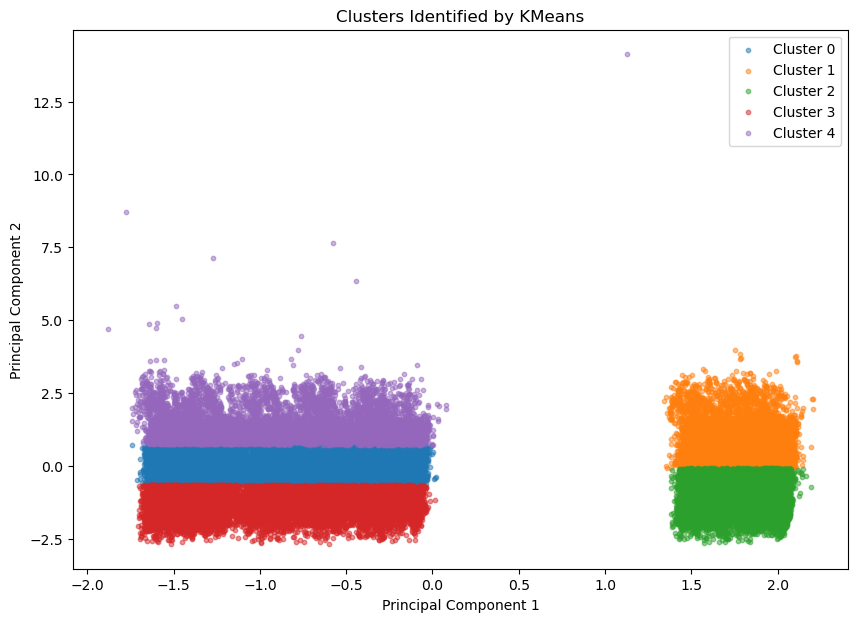

In [56]:
# Visualize the clusters
visualize_clusters(kmeans, 'KMeans', pca_df)

## Birch

In [57]:
# Instantiate model
birch = Birch(n_clusters=5)

In [58]:
# Evaluate the model and log the results
evaluate_clustering_model(birch, pca_df, 'Birch', clustering_log)

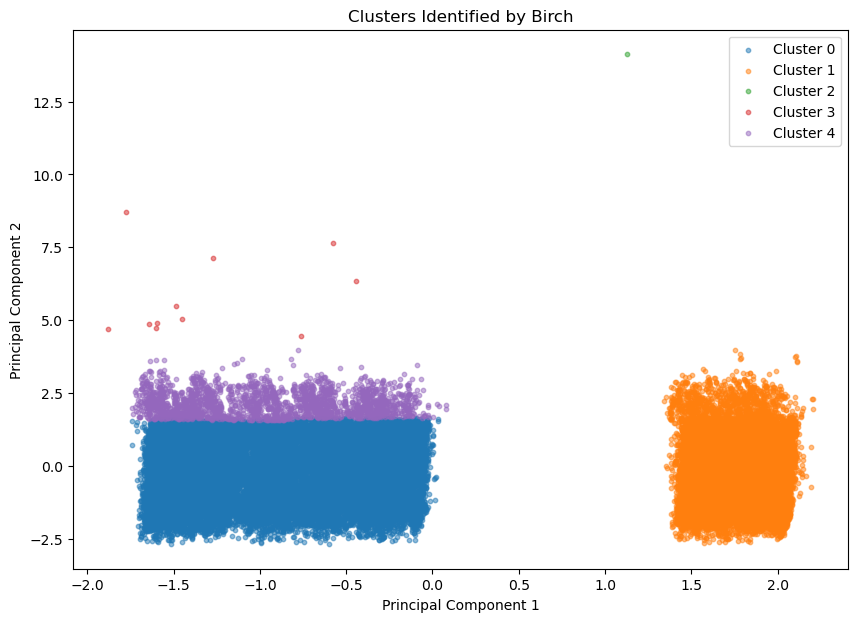

In [59]:
# Visualize the clusters
visualize_clusters(birch, 'Birch', pca_df)

## DBSCAN

In [63]:
# Instantiate model
dbscan = DBSCAN()

In [64]:
# Evaluate the model and log the results
evaluate_clustering_model(dbscan, pca_df, 'DBSCAN', clustering_log)

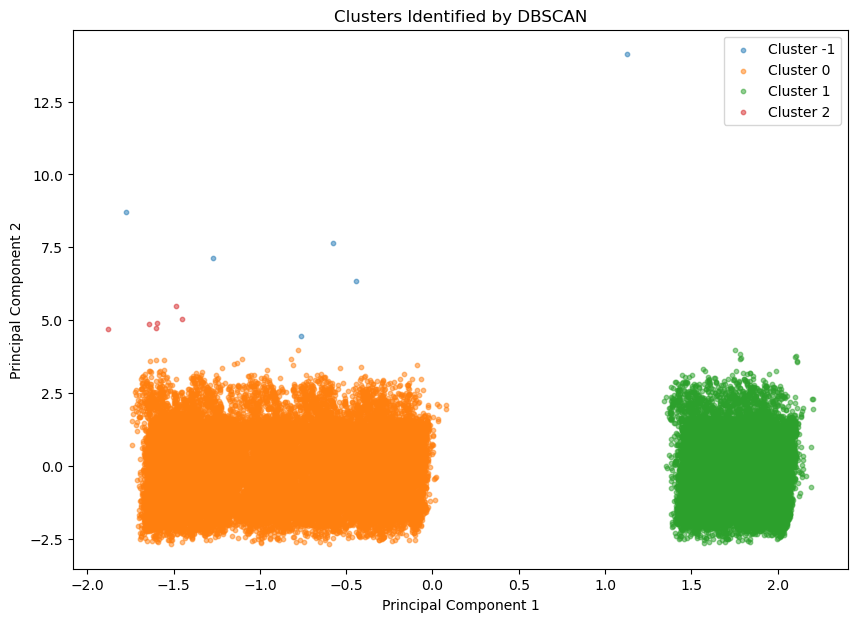

In [65]:
# Visualize the clusters
visualize_clusters(dbscan, 'DBSCAN', pca_df)

## Results

In [78]:
# Convert the log to a DataFrame
results_df = pd.DataFrame(clustering_log).T

# Display results
results_df

,silhouette_score,calinski_harabasz_index
KMeans,0.454672,66603.087461
Birch,0.495439,16695.256725
DBSCAN,0.703515,91931.962389
OPTICS,-0.199377,15.360832


The two evaluation metrics used are as follows:

- Silhouette Score: This metric measures how similar an object is to its own cluster compared to other clusters. Values range from -1 to 1, with higher values indicating better-defined clusters.

- Calinski-Harabasz Index: This metric indicates the density and separation of the clusters, where higher values suggest that the clusters are dense and well-separated.

Based purely on these metrics, DBSCAN appears to be the best model, as it has the highest Silhouette Score and Calinski-Harabasz Index. However, when visually inspecting the clustering results, DBSCAN tends to group the data into two main clusters and isolates some outliers into separate clusters. Given the nature of the data, this clustering does not align well with our expectations, as it oversimplifies the structure by creating just two primary clusters.

Therefore, despite DBSCAN's superior scores, it does not provide the most meaningful segmentation for our data. Instead, we will opt for the second-best technique, KMeans clustering, which, while scoring slightly lower, offers a more appropriate and interpretable clustering structure for our needs.

# KMeans Clustering

Now that we are using KMeans clustering, lets put back in the full dataset rather than the PCA dataset and run the clustering model to get our client labels. 

Then we will attach the labels back to the original unscaled DataFrame to attempt to find interpret the clusters. 

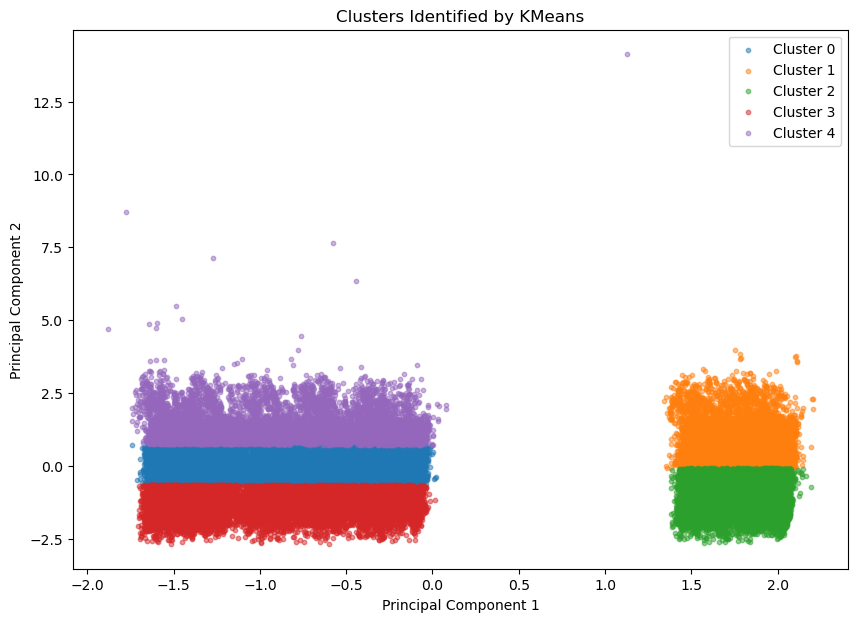

In [79]:
# Instantiate and fit the model
kmeans = KMeans(n_clusters=5, random_state=19)
clusters = kmeans.fit_predict(transformed_clustering_df)

# Reattach the cluster labels to the original unscaled dataset
clustering_df['cluster'] = clusters

# Visualize the clusters using the original data or scaled data
visualize_clusters(kmeans, 'KMeans', pca_df)

## Cluster Interpretation

In [87]:
clustering_df.head()

,category,amt,gender,city_pop,job,hour,day_of_week,month,is_weekend,time_of_day,age,cluster
0,home,77.90,0,1078,medical and healthcare,12,2,6,0,afternoon,35,0
1,health_fitness,47.78,0,134056,medical and healthcare,19,5,4,1,evening,44,2
2,misc_net,690.81,0,238602,business and management,22,0,1,0,evening,31,4
3,gas_transport,65.85,0,640470,business and management,9,4,8,0,morning,58,3
4,shopping_net,67.11,0,267,business and management,16,0,1,0,afternoon,19,0


### Numeric Columns

In [90]:
# Select only numerical columns (excluding the 'cluster' column)
numerical_columns = clustering_df.select_dtypes(include=['float64', 'int32', 'int64']).columns

# Calculate the mean for numerical columns grouped by 'cluster'
cluster_numerical_stats = clustering_df.groupby('cluster')[numerical_columns].mean()

# Display DataFrame
cluster_numerical_stats

,amt,gender,city_pop,hour,day_of_week,month,is_weekend,age,cluster
cluster,,,,,,,,,
0,59.571730,0.571214,4.183427e+04,17.905525,1.756012,5.990266,0.000000,47.292657,0.0
1,124.057292,0.617533,1.515673e+06,13.192397,3.231187,5.964313,0.359969,45.183863,1.0
2,73.448923,0.537209,4.229800e+04,12.496937,5.551704,6.412283,1.000000,50.973999,2.0
3,93.008025,0.498385,4.046414e+04,5.385858,1.732576,5.949414,0.000000,56.671836,3.0
4,936.996718,0.437709,5.610185e+04,18.979906,3.105827,5.711989,0.311788,55.036169,4.0


**Cluster 0**

- Spends the least in terms of their average purchase amount.
- Has a larger proportion of females than males.
- Tend to purchase items later at night and early in the week.
    - No purchases on the weekend. 
- They are second youngest.

**Cluster 1**

- Spends the second-most but still generally speaking, they are not large purchases.
- Has a larger proportion of females than males.
- Tend to the majority of their purchases in the afternoon and in the middle of the week.
- This is the youngest group.

**Cluster 2**

- Middle of the road with spending but again on the low side.
- More female than male, but more balanced than others.
- Tend to the majority of their purchases in the afternoon and on the weekend.
    - Only makes purchases on the weekend.
- Middle of the road with age as well.

**Cluster 3**

- Middle of the road with spending but again on the low side.
- They are more male than female, but more balanced than others.
- Spend their money early in the day and week.
    - No purchases on the weekend.
- Oldest grouping.

**Cluster 4**

- This group by and large spends the most. Over 800% more than the next largest group.
- More male leaning than female.
- They spend their money much later in the day and balanced throughout the week.
- They are toward the older end of the spectrum, second oldest group. 

### Categorical Columns

In [128]:
# Select only categorical columns
categorical_columns = clustering_df.select_dtypes(include=['object']).columns

# Create an empty dictionary to store the results for each categorical column
cluster_counts = {}

# Loop through each categorical column and calculate value counts for each cluster
for col in categorical_columns:
    # Calculate the value counts for each cluster
    counts = clustering_df.groupby('cluster')[col].value_counts().unstack(fill_value=0)
    
    # Store the result in the dictionary
    cluster_counts[col] = counts

# Convert each dictionary entry to a separate DataFrame
dataframes = {}
for col, counts_df in cluster_counts.items():
    # Rename the columns to reflect the categorical variable being analyzed
    counts_df.columns.name = None
    counts_df.reset_index(inplace=True)
    counts_df.columns = [col] + list(counts_df.columns[1:])
    
    # Store the DataFrame in the 'dataframes' dictionary
    dataframes[col] = counts_df

#### Category

In [129]:
# Display the DataFrame
dataframes['category']

,category,entertainment,food_dining,gas_transport,grocery_net,grocery_pos,health_fitness,home,kids_pets,misc_net,misc_pos,personal_care,shopping_net,shopping_pos,travel
0,0,1343,1387,13,23,217,1509,2170,2006,182,686,1679,914,1143,700
1,1,99,91,93,57,138,66,98,112,78,72,85,143,118,39
2,2,1002,885,1414,450,1628,845,1237,1114,613,843,951,913,1069,420
3,3,395,255,2660,850,2923,67,99,103,942,849,83,708,847,52
4,4,52,0,0,0,0,0,0,0,707,51,0,1450,687,39


#### Jobs

In [130]:
# Display the DataFrame
dataframes['job']

,job,agriculture and rural affairs,"arts, media, and design",business and management,education and research,engineering and technology,law and public service,medical and healthcare,science and environment,transportation and logistics
0,0,70,1941,5304,1367,2188,197,2536,260,109
1,1,0,292,266,82,231,110,294,14,0
2,2,81,1873,5026,1291,2129,190,2419,300,75
3,3,67,1508,4110,1024,1828,187,1799,245,65
4,4,18,434,1159,259,433,75,483,86,39


#### Time of Day

In [131]:
# Display the DataFrame
dataframes['time_of_day']

,time_of_day,afternoon,evening,morning,night
0,0,6303,7599,70,0
1,1,381,440,202,266
2,2,3833,4044,2498,3009
3,3,540,0,4515,5778
4,4,310,2301,60,315


**Cluster 0**

- category
    - home/ kid and pets / home care / travel
- job
    - business and management / medical and healthcare 
- time of day
    - evening and afternoon

**Cluster 1**

- category
    - shopping net / grocery pos
- job
    - arts, media, and design / medical and healthcare
- time of day
    - evening and afternoon

**Cluster 2**

- category
    - grocery pos / gas transport 
- job
    - business and management / medical and healthcare / engineering and technology
- time of day
    - even spending habits across all hours

**Cluster 3**

- category
    - grocery pos / gas transport
- job
    - business and management / engineering and technology
- time of day
    - morning and night

**Cluster 4**

- category
    - shopping net / misc net
- job
    - business and management / engineering and technology / arts, media, and design
- time of day
    - evening

## Results

By focusing on these strategies, ABC bank can better engage with Cluster 4 and effectively grow their customer base in this high-value demographic.

**Demographics**
- Age: Approximately 55 years old
- Gender: Slightly male-leaning but balanced overall
- Primary Shopping Channel: Online

**Industries**
- Business and Management
- Engineering and Technology
- Arts, Media, and Design

**Spending Behavior**
- High Spending: Total spending is notably higher compared to other clusters, especially in categories like "shopping_net" and "shopping_pos."
- Low Spending: Minimal spending in categories like "gas_transport" and "food_dining."

**Engagement Channels**
- Social Media: Engage with this demographic on platforms like LinkedIn and Facebook by sharing relevant content and interacting in industry-specific groups.

**Partnerships and Sponsorships**
- Industry Events: Sponsor or participate in events and conferences related to business, technology, and design. This can help build brand awareness and credibility within these professional circles.
- Influencers: Collaborate with influencers or thought leaders in the targeted industries.

**Monitoring and Optimization**
- Performance Metrics:
    - Track engagement rates, conversion rates, and ROI for the targeted ads and content.
    - Monitor customer feedback and satisfaction levels to refine your approach.

- Continuous Improvement:
    - Use A/B testing to optimize ad designs, messaging, and offers.
    - Regularly update content and strategies based on performance data and industry trends.